# MNIST dataset - Classifiying hand-written digits

Let's start by loading libraries.

In [1]:
import jax 
import jax.numpy as jnp 
import flax.linen as nn 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optax
import numpy as np
from sklearn import preprocessing
from sklearn.datasets import load_digits

<Figure size 640x480 with 0 Axes>

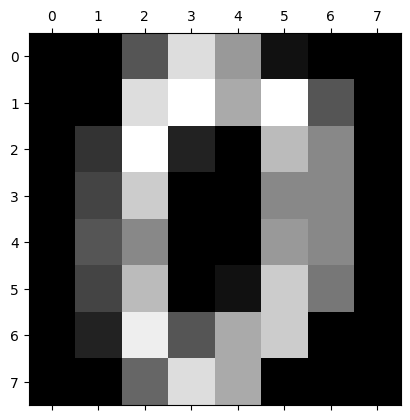

In [2]:
# Load data
digits = load_digits()
Images = digits.data
target = digits.target
#visualize
plt.gray()
plt.matshow(digits.images[0])
plt.show()

In [3]:
class MLP(nn.Module):
    """
    Multi-layer Perceptron
    
    This class represents a Multi-layer Perceptron (MLP) model, which is a type of feedforward neural network.
    MLPs consist of multiple layers of interconnected nodes (called neurons) and are commonly used for
    classification tasks.
    
    Parameters:
        nhidden_units (int): Number of hidden units in each layer.
        nlayers (int, optional): Number of layers in the MLP. Defaults to 1.
        nclasses (int, optional): Number of output classes (categories). Defaults to 10.
    
    Attributes:
        layers (list): List of Dense layers representing the hidden layers in the MLP.
        final_layer (Dense): Final Dense layer for producing the output of the MLP.
    """
    nhidden_units: int
    nlayers = 1
    nclasses = 10
    
    def setup(self):
        """
        Setup the MLP model by creating the hidden layers and the final output layer.
        """
        self.layers = [nn.Dense(self.nhidden_units) for n in range(self.nlayers)]
        self.final_layer = nn.Dense(self.nclasses)
        
    @nn.compact
    def __call__(self, x):
        """
        Perform a forward pass through the MLP.
        
        Args:
            x (jax.interpreters.xla.DeviceArray): Input data.
            
        Returns:
            jax.interpreters.xla.DeviceArray: Output of the MLP.
        """
        for k, lyr in enumerate(self.layers):
            x = lyr(x)
            x = nn.relu(x)
        x = self.final_layer(x)
        x = nn.activation.softmax(x)
        return x
# initializing the optimizer
learning_rate = 1e-3
optx = optax.adam(learning_rate=learning_rate)

The target values we loaded are integers. We now write a code to one-hot encode them. For example, the category "1" would become [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0].

In [4]:
def one_hot_encoder(x):
    """
    One-Hot Encoder
    
    Converts an array of categorical labels to one-hot encoded representation.
    
    Args:
        x (ndarray): Array of categorical labels.
        
    Returns:
        ndarray: One-hot encoded representation of the input labels.
    """
    nclasses = 10  # Number of classes/categories
    out = np.zeros((x.shape[0], nclasses))  # Initialize an array of zeros with shape (number of samples, number of classes)
    
    for i, x_ in enumerate(x):
        out[i, x_] = 1.  # Set the corresponding class index to 1 in each sample
        
    return out
target_oh = one_hot_encoder(target)
# test
print(f"target value: {target[40]}, corresponding one-hot vector: {target_oh[40,:]}")

target value: 8, corresponding one-hot vector: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


## Fitting

In [5]:
# split the data into training and test data
x_train, x_test, y_train, y_test = train_test_split(Images, target_oh, test_size=0.33, random_state=42)
# initialize the neural network 
model = MLP(256)
params = model.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def cat_cross_entropy(params, x, y_true):
    """
    Categorical Cross Entropy Loss Function

    This function calculates the categorical cross entropy loss between the predicted
    probabilities and the true one-hot encoded labels.

    Parameters:
        params (jax.interpreters.xla.DeviceArray): Model parameters.
        x (jax.interpreters.xla.DeviceArray): Input data.
        y_true (jax.interpreters.xla.DeviceArray): True one-hot encoded labels.

    Returns:
        jax.interpreters.xla.DeviceArray: Mean categorical cross entropy loss.
    """
    # Forward pass to obtain predicted probabilities
    y_pred = model.apply(params, x)

    # Calculation of the loss per example
    loss_per_example = jnp.sum(-y_true * jnp.log(y_pred), axis=1)

    # Return the mean loss across all examples
    return jnp.mean(loss_per_example)

loss_fn = cat_cross_entropy
loss_grad_fn = jax.value_and_grad(cat_cross_entropy) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 1000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

epoch: 0, loss function: 7.451040744781494
epoch: 100, loss function: 0.03282686322927475
epoch: 200, loss function: 0.007416482083499432
epoch: 300, loss function: 0.003187159076333046
epoch: 400, loss function: 0.0017350796842947602
epoch: 500, loss function: 0.0010891821002587676
epoch: 600, loss function: 0.0007527557318098843
epoch: 700, loss function: 0.0005526680615730584
epoch: 800, loss function: 0.0004230765625834465
epoch: 900, loss function: 0.000334318436216563


Test the learned function on some random input.

In [6]:
sample = np.random.randint(low=0, high=x_test.shape[0], size=(1,))
y_pred = np.argmax(model.apply(params, x_test[sample,:]))
print(f"ture value: {np.argmax(y_test[sample,:])} predicted: {y_pred}")


ture value: 5 predicted: 5


Evaluate the training and test errors.

In [7]:
tr_loss = cat_cross_entropy(params, x_train, y_train)
te_loss = cat_cross_entropy(params, x_test, y_test)
print(f"training loss: {tr_loss}, test loss: {te_loss}")

training loss: 0.00027058576233685017, test loss: 0.09268166869878769


We now evaluate the training and test error. Does the model suffer from overfitting? from underfitting? from both?

Experiment with the following parameters and see how that affects over-/underfitting. 

- Complexity of the neural network; by increasing the number of hidden units or number of layers.
- Add a regularization layer; it prevents the weights of the neural network from becoming so big. 